# Tracking without bells and whistles
## Paper : https://arxiv.org/pdf/1903.05625.pdf

**A detector is all you need**
Tracker에서 Track이라는 object 당, 객체를 갖는다. (SORT 에서 Tracker Class에 해당한다고 생각하면 됌.)
Detection의 RoI Pooling을 통해 regress하는 성질을 이용



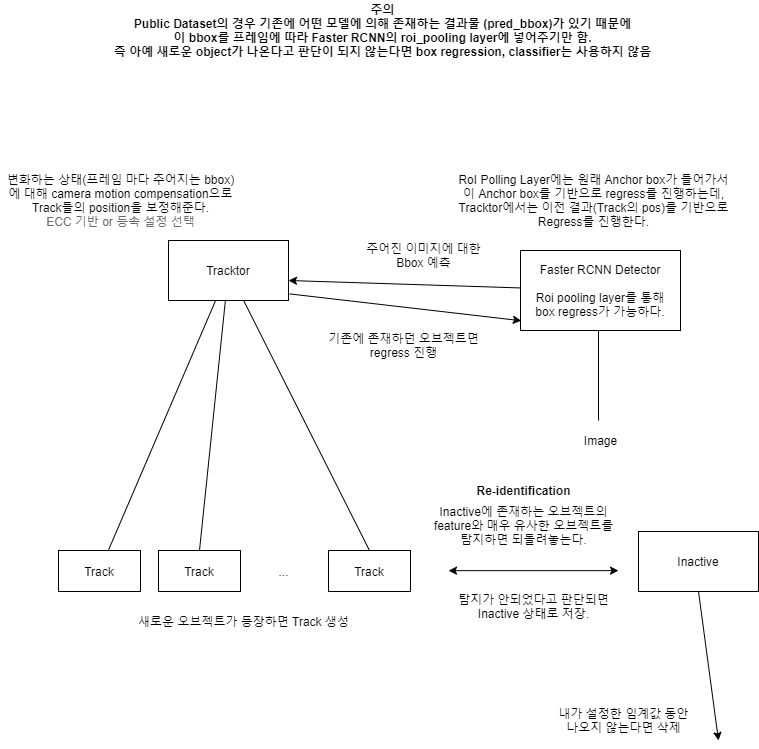

In [1]:
from collections import deque

import numpy as np
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from torchvision.ops import clip_boxes_to_image, nms
import cv2

## Utils

In [ ]:
def make_pos(cx, cy, width, height): # motion compensation 처리 시 사용되는 좌표
    return torch.Tensor([[
        cx - width / 2,
        cy - height / 2,
        cx + width / 2,
        cy + height / 2
    ]]).cuda()


def get_center(pos):
    x1 = pos[0, 0]
    y1 = pos[0, 1]
    x2 = pos[0, 2]
    y2 = pos[0, 3]
    return torch.Tensor([(x2 + x1) / 2, (y2 + y1) / 2]).cuda()


def get_width(pos):
    return pos[0, 2] - pos[0, 0]


def get_height(pos):
    return pos[0, 3] - pos[0, 1]

""" Camera Motion Comprehension 부분임. 잘 모르겠다 ㅜㅜ """

def warp_pos(pos, warp_matrix):
    p1 = torch.Tensor([pos[0, 0], pos[0, 1], 1]).view(3, 1)
    p2 = torch.Tensor([pos[0, 2], pos[0, 3], 1]).view(3, 1)
    p1_n = torch.mm(warp_matrix, p1).view(1, 2)
    p2_n = torch.mm(warp_matrix, p2).view(1, 2)
    return torch.cat((p1_n, p2_n), 1).view(1, -1).cuda()


def bbox_overlaps(boxes, query_boxes):
    """
    Parameters
    ----------
    boxes: (N, 4) ndarray or tensor or variable
    query_boxes: (K, 4) ndarray or tensor or variable
    Returns
    -------
    overlaps: (N, K) overlap between boxes and query_boxes
    """
    if isinstance(boxes, np.ndarray):
        boxes = torch.from_numpy(boxes)
        query_boxes = torch.from_numpy(query_boxes)
        out_fn = lambda x: x.numpy()  # If input is ndarray, turn the overlaps back to ndarray when return
    else:
        out_fn = lambda x: x

    box_areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    query_areas = (query_boxes[:, 2] - query_boxes[:, 0] + 1) * (query_boxes[:, 3] - query_boxes[:, 1] + 1)

    iw = (torch.min(boxes[:, 2:3], query_boxes[:, 2:3].t()) - torch.max(boxes[:, 0:1],
                                                                        query_boxes[:, 0:1].t()) + 1).clamp(min=0)
    ih = (torch.min(boxes[:, 3:4], query_boxes[:, 3:4].t()) - torch.max(boxes[:, 1:2],
                                                                        query_boxes[:, 1:2].t()) + 1).clamp(min=0)
    ua = box_areas.view(-1, 1) + query_areas.view(1, -1) - iw * ih
    overlaps = iw * ih / ua
    return out_fn(overlaps)



## Track Class (SORT에서 Tracker에 속한다.)

In [ ]:
class Track(object):
    # 각 Track이 가져야 할 요소를 다 가지고 있는다.
    def __init__(self, pos, score, track_id, features, inactive_patience, max_features_num, mm_steps):
        self.id = track_id
        self.pos = pos # tracker 에서의 state position (tracker 기준 현재 상태인듯 )
        self.score = score # track (object)에 해당하는 점수임.
        self.features = deque([features]) # features
        self.count_inactive = 0 # inactive가 얼마동안 되었는지 세기.
        self.inactive_patience = inactive_patience # 이거 모르겠음..
        self.max_features_num = max_features_num # features의 최대 길이 설정
        self.last_pos = deque([pos.clone()], maxlen=mm_steps + 1) # last_pos (어느 step까지 동선을 저장 할 것인가.)
        self.last_v = torch.Tensor([]) # velocity
        self.gt_id = None

    def has_positive_area(self):
        return self.pos[0,2] > self.pos[0,0] and self.pos[0,3] > self.pos[0,1]

    def add_features(self, features): # 이 track에 대한 feature. 지금 까지 들어왔던 trajectory (동일 object)에 대한 features
        self.features.append(features)
        if len(self.features) > self.max_features_num: # feature를 얼마나 저장 할 것인가.
            self.features.popleft() # 오래 된거를 뺀다.

    def test_features(self, test_features): # Re-Identification에 사용됌.
        # test_features와 이 track object와의 비교
        if len(self.features) > 1:
            features = torch.cat(list(self.features), dim=0) # deque형태를 list 형태로 바꾸고 dim = 0 기준으로 concat.
        else :
            features = self.features[0]
        features = features.mean(0, keepdims=True)
        dist = F.pairwise_distance(features, test_features, keepdim=True) # Default ->  Euclidean Distance로 두 features data distance를 구한다.
        return dist # featuers랑 test features 간의 distance (비교)

    def reset_last_pos(self): # inactive가 되었다가 다시 되돌아 올 수도 있음.
        self.last_pos.clear()
        self.last_pos.append(self.pos.clone())


## Tracker Class

전처리에서 진행까지 전부 여기서 시행된다.

In [ ]:

class Tracker :
    # ONE CLASS (PEDESRIAN)
    cl = 1
    """
        obj_detect = FASTER RCNN (detection model)
        reid_detect = RESNET FEATURE EXTRACTOR
    """
    def __init__(self, obj_detect, reid_network, tracker_cfg):
        self.obj_detect = obj_detect # detection model (논문 상에서는 Faster RCNN을 사용했다.)
        self.reid_detect = reid_network # official 에서는 resnet을 사용해서 추출한다. (Siamese CNN)
        self.detection_person_thresh = tracker_cfg['detection_person_thresh'] # 임계값
        self.regression_person_thresh = tracker_cfg['regression_person_thresh'] # 임계값
        self.detection_nms_thresh = tracker_cfg['detection_nms_thresh'] # 임계값
        self.regression_nms_thresh = tracker_cfg['regression_nms_thresh'] # 임계값
        self.public_detections = tracker_cfg['public_detections'] # boolean : 공개된 데이터셋인가? (특정 모델의 result(pred bbox)를 가지고 올 수 있는가?)
        self.inactive_patience = tracker_cfg['inactive_patience'] # 임계값. 이 수치보다 오랜 프레임동안 나타나지 않으면 track을 아예 삭제한다.
        self.do_reid = tracker_cfg['do_reid'] # boolean : T,F -> Re-identification 시행 할 것인지.
        self.max_features_num = tracker_cfg['max_features_num'] # Track에서 feature의 수를 얼만큼 고려할 것인가.
        self.reid_sim_threshold = tracker_cfg['reid_sim_threshold'] # Reid에서 distance에 대한 임계값. 얘보다 작아야 탐지 할 거임.
        self.reid_iou_threshold = tracker_cfg['reid_iou_threshold']
        self.do_align = tracker_cfg['do_align'] # ECC를 사용한 motion compensation 적용 여부. 사용 안하면 적은 수치의 등속으로 가정한다.
        self.motion_model_cfg = tracker_cfg['motion_model'] # motion compensation 자체 사용 여부.

        self.warp_mode = getattr(cv2, tracker_cfg['warp_mode'])
        self.number_of_iterations = tracker_cfg['number_of_iterations']
        self.termination_eps = tracker_cfg['termination_eps']
        self.tracks = [] # Track들 (class)
        self.inactive_tracks = [] # inactive시킨 tracks
        self.track_num = 0 # 지금까지 만들어진 track 수.
        self.im_index = 0 # 지금 tracker 몇번 실행 했는지.
        self.results = {}

    def reset(self, hard=True):
        self.tracks = [] # 동선 초기화
        self.inactive_tracks = []

        if hard :
            self.track_num = 0
            self.results = {}
            self.im_index = 0

    """
        def tracks_to_inactive
    """
    def tracks_to_inactive(self, tracks): # Track class를 받아온다.
        self.tracks = [t for t in self.tracks if t not in tracks] # input으로 받은 Track들을 제외하고 self.tracks로 지정해준다. (input으로 들어온 친구들은 inactive)
        for t in tracks :
            t.pos = t.last_pos[-1]
        self.inactive_tracks += tracks # inactive에 저장.


    """
        Track을 추가한다. SORT에서 Tracker를 추가해줬던거를 생각하면 될 듯.
        track이 deque에 들어가는 순서를 여겨봐야 할 것 같음.
        append로 사용해서 뒷 부분에 들어감.
    """
    def add(self, new_det_pos, new_det_scores, new_det_features):
        # 새로운 오브젝트에 대한 track 추가
        # pos, score, track_id, features, inactive_patience, max_features_num, mm_steps : Tracker Parameter
        num_new = new_det_pos.size(0) # 아마 오브젝트의 수를 의미하는 것 같다. 오브젝트 하나당 새로운 트래커가 나오는듯.
        for i in range(num_new):
            self.tracks.append( # pos (x,y,w,h)
                Track(
                    pos = new_det_pos[i].view(1,-1),
                    score = new_det_scores[i], # score
                    track_id = self.track_num + i, # 지금까지 만들어진 친구들의 수 + index
                    features = new_det_features[i].view(1,-1), # features는 어떤 방식으로 나오느지 잘모르겠는데, 쨌든 features로 해당 object에 대한 features를 준다.
                    inactive_patience = self.inactive_patience, # 잘 모르겠음.
                    max_features_num = self.max_features_num,
                    mm_steps=self.motion_model_cfg['n_steps'] if self.motion_model_cfg['n_steps'] >0 else 1 # Track에서 동선 저장을 얼마나 할 건지.
                )
            )
        self.track_num += num_new # 사용하고 있는 track의 수를 수정.

    """
        def regress_tracks
        Input : blob (dictionary 형태이며 img name을 가지고 있음.)
        clip_boxes_to_image(box:[x1,y1,x2,y2], image_size:[w,h]) 이미지 사이즈를 넘을 경우 클립해준다. Clamp 해줌. <colab 사진 넣어보기.>
    """
    def regress_tracks(self, blob):
        # 우선 active track에 있는 position들을 가져오자. (len(self.tracks). 4)
        pos = self.get_pos()

        # Regress
        boxes, scores = self.obj_detect.predict_boxes(pos) # position이 들어왔을 떄 box를 추가적으로 predict(즉 regression)
        # predict_boxes -> faster rcnn의 roi heads에 해당한다. pos를 proposal로 보고 이를 기준으로 roi pooling 작업.
        # 즉 pos가 anchor box의 역할이 되는 듯 싶다.

        pos = clip_boxes_to_image(boxes, blob['img'].shape[-2:]) # box사이즈가 이미지 사이즈를 넘어주면 clamp

        s = []
        for i in range(len(self.tracks) -1 ,-1, -1): # index를 뒤에서부터.
            t = self.tracks[i] # append 메서드를 사용할거라서 뒤에서부터 가져온다.
            t.score = scores[i] # 초기화 됐던 track에 regression 후 나온 score를 할당해주기.
            if scores[i] <= self.regression_person_thresh :
                self.tracks_to_inactive([t]) # 만약 해당 track의 score가 person thresh보다 낮다면 inactive 시키자. (사라졌다고 판별.)
            else : # score가 임계값을 넘었다면 s에 score를 넣어주고 이를 결과값 리스트에 append 시켜주자.
                s.append(scores[i])
                t.pos = pos[i].view(1,-1)

        return torch.Tensor(s[::-1]).cuda() # 후입의 track에 대해서 먼저 score를 넣어줬기 때문에 list를 reverse

    """
        모든 active track에서 positions를 가져온다.
    """
    def get_pos(self):
        if len(self.tracks) == 1: # 사용 중인 track의 수가 1
            pos = self.tracks[0].pos # 그냥 가져오기
        elif len(self.tracks) > 1: # 1보다 크면
            pos = torch.cat([t.pos for t in self.tracks], 0) # torch.tensor로 만들어버리자. (len(self.tracks). 4)
        else :
            pos = torch.zeros(0).cuda() # 없으면 0
        return pos
    """
        모든 active track에서 features를 가져온다.
    """
    def get_features(self):
        if len(self.tracks) == 1: # 사용 중인 track의 수가 1
            features = self.tracks[0].features # 그냥 가져오기
        elif len(self.tracks) > 1: # 1보다 크면
            features = torch.cat([t.features for t in self.tracks], 0) # torch.tensor로 만들어버리자. (len(self.tracks). 4)
        else :
            features = torch.zeros(0).cuda() # 없으면 0
        return features

    """
        모든 inactive track에서 features를 가져온다.
    """
    def get_inactive_features(self):
        if len(self.inactive_tracks) ==1 :
            features = self.inactive_tracks[0].features
        elif len(self.inactive_tracks) > 1:
            features = torch.cat([t.features for t in self.inactive_tracks],0)
        else :
            features = torch.zeros(0).cuda()
        return features

    """
       re identification : occulusion 등에 대한 대처.
    """
    def reid(self, blob, new_det_pos, new_det_scores):
        new_det_features = [torch.zeros(0).cuda() for _ in range(len(new_det_pos))] # new det pos -> object의 수 만큼 list 초기화

        if self.do_reid:
            new_det_features = self.reid_network.test_rois(
                blob['img'], new_det_pos
            ).data # reid network로 feature를 뽑는다. 이 떄 blob['img'] (BS, c, h ,w)에 대해서 h,w를 부여된 new_det_pos에 대해 crop해서 forward 시킨다.

            if len(self.inactive_tracks) >= 1: # inactive_tracks가 존재한다면,
                dist_mat, pos = [],[]  # Reid는 inactive된 물체에 대해 tracking 해야함.
                """
                    Track.test_features(test_feature) -> 주어진 test feature (det box에 대한 feature)와 track에 존재하는 feature 간의 관계. distance
                    이 떄 track에 존재하는 trajectory(동선)의 boxes에 대한 feature에 mean을 취한다. (대표되는 값.)
                    
                    여기에서는 각각의 inactive_tracks에 대해 모든 new_det_features 사이의 distance를 계산한다. N by K 형태.
                """
                for t in self.inactive_tracks:  # 주어진 img의 새로운 bbox position에 대해서 feature를 reid network로 추출하고 이를 기존의 object(track)과 비교. (distance)
                    dist_mat.append(torch.cat([t.test_features(feat.view(1,-1)) for feat in new_det_features],dim=1))
                    pos.append(t.pos)
                if len(dist_mat) > 1: # inactive가 2개 이상 있으면,
                    dist_mat = torch.cat(dist_mat,0)
                    pos = torch.cat(pos, 0)
                else :
                    dist_mat = dist_mat[0]
                    pos = pos[0]

                iou = bbox_overlaps(pos, new_det_pos) # N by K SORT에서 batch iou method와 동일하다.
                iou_mask = torch.ge(iou, self.reid_iou_threshold) # iou threshold 기준으로 mask 생성
                iou_neg_mask = ~iou_mask

                # neg_mask -> iou threshold 못 넘으면 True. 즉 1임. neg mask에 해당하는 distance matrix 부분에 값을 1000로 설정해서 못쓰게 만들어버리자. (둘 사이의 거리가 멀어지도록.)
                dist_mat = dist_mat * iou_mask.float() + iou_neg_mask.float() * 1000
                dist_mat = dist_mat.cpu().numpy() # 쿠다와 텐서에서 탈출!
                """
                    존재하는 inactive_tracks의 trajectory들에 대해서 (trajectory_num, features channels) 이런 형태일 것 같은데, (mean된 상태, but dim은 보존됌.)
                    여기에 새로운 친구들과의 비교가 이루어진다.
                    
                    inactive_tracks (사라졌다고 판단한 objects)들과 새롭게 받아온 objects features 사이에 대한 관계 파악. Hungarian Algorithm
                """

                row_ind, col_ind = linear_sum_assignment(dist_mat) # matching algorithm (inactive들과 새롭게 탐지한 얘들.)
                # row_ind -> inactive_track, col_ind -> new detect
                assigned = [] # 할당 된 index를 넣어주자. matching에 성공했지만 threshold를 못 넘었을 수도 있으니까.
                remove_inactive = []
                for r, c in zip(row_ind, col_ind):
                    if dist_mat[r,c] <= self.reid_sim_threshold: # distance 형식이니까. (cost가 적어야됌.)
                        t = self.inactive_tracks[r] # 위 조건을 만족하는 얘는 tracks로 복귀시켜 주자 ㅎㅎ 아래는 track 초기화
                        self.tracks.append(t)
                        t.count_inactive = 0
                        t.pos = new_det_pos[c].view(1,-1)
                        t.reset_last_pos() # 해당 track을 복귀 시켜줬으니까 pos도 넣어주고 해주자.
                        t.add_features(new_det_features[c].view(1,-1))
                        assigned.append(c)
                        remove_inactive.append(t)

                for t in remove_inactive: # 진짜 삭제
                    self.inactive_tracks.remove(t)

                keep = torch.Tensor([i for i in range(new_det_pos.size(0)) if i not in assigned]).long.cuda() # index에서 할당 되지 않은 얘들은 새로운 오브젝트의 index.
                if keep.nelement()>0:
                    new_det_pos = new_det_pos[keep]
                    new_det_features = new_det_features[keep]
                    new_det_scores = new_det_scores[keep]
                else : # 전부 기존에 있었던 얘들이면 비어있는 리턴
                    new_det_pos = torch.zeros(0).cuda()
                    new_det_features = torch.zeros(0).cuda()
                    new_det_scores = torch.zeros(0).cuda()

        return new_det_pos, new_det_scores, new_det_features

    def get_appearance(self, blob): # data directory
        """All active track에 대한 feature 가져오기. (image가 주어지면 해당 image(per frame)에 속한 objects의 featuers)"""
        new_features = self.reid_network.test_rois(blob['img'], self.get_pos())
        return new_features

    def add_features(self, new_features):
        """get appearance에서 뽑았던 features들을 각 track에 할당해주자."""
        for t,f in zip(self.tracks, new_features):
            t.add_features(f.view(1,-1))

    def align(self, blob):
        """Camera motion에 따라 active, inactive track에 position 할당. CMC 이부분은 진짜 모르겠음.."""
        if self.im_index > 0:

            im1 = np.transpose(self.last_image.cpu().numpy(), (1,2,0)) # last_image는 실제 실행되는 step method에서 정해진다. 진행 한 후 그 떄의 frame을 저장하는 듯 싶다.
            im2 = np.transpose(blob['img'][0].cpu().numpy(), (1,2,0)) # blob['img']가 어떤 형식으로 되어있는지 알아야 할듯.
            im1_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
            im2_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
            warp_matrix = np.eye(2,3,dtype=np.float32) # 대각행렬 2 by 3 [[1,0,0],[0,1,0]]
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, self.number_of_iterations, self.termination_eps) # ECC(Enhanced Correlation Coefficient )을 통한 카메라 모션 보상
            cc, warp_matrix = cv2.findTransformECC(im1_gray, im2_gray, warp_matrix, self.warp_mode, criteria)
            warp_matrix = torch.from_numpy(warp_matrix)

            for t in self.tracks:
                t.pos = warp_pos(t.pos, warp_matrix)
                # t.pos = clip_boxes(Variable(pos), blob['im_info'][0][:2]).data

            if self.do_reid:
                for t in self.inactive_tracks:
                    t.pos = warp_pos(t.pos, warp_matrix)

            if self.motion_model_cfg['enabled']:
                for t in self.tracks:
                    for i in range(len(t.last_pos)):
                        t.last_pos[i] = warp_pos(t.last_pos[i], warp_matrix)

    def motion_step(self, track):
        # 주어진 track의 position을 track의 last v로 update (velocity인듯. motion)
        if self.motion_model_cfg['center_only']:
            center_new = get_center(track.pos) + track.last_v
            track.pos = make_pos(*center_new, get_width(track.pos), get_height(track.pos))
        else :
            track.pos = track.pos + track.last_v

    def motion(self): # 지난 steps에 대해 고려하는 simple linear motion model
        for t in self.tracks:
            last_pos = list(t.last_pos)

            if self.motion_model_cfg['center_only']:
                vs = [get_center(p2) - get_center(p1) for p1, p2 in zip(last_pos, last_pos[1:])]
            else:
                vs = [p2 - p1 for p1, p2 in zip(last_pos, last_pos[1:])]

            t.last_v = torch.stack(vs).mean(dim=0) # t.last_v를 등속으로 가정
            self.motion_step(t)

        if self.do_reid: # reid의 경우 inactive도 보상 고려 해줘야 한다.
            for t in self.inactive_tracks:
                if t.last_v.nelement() > 0:
                    self.motion_step(t)

    """
        실행부
        Input : Image Information
        
        public dataset인 경우 새로운 object가 나오지 않는 이상 box regressor, classifier 사용 하지 않음. 다른 모델들로 나온 결과를 그냥 가져와서 더 나은 결과를 만들고자 함.
    """
    def step(self, blob): # data가 주어졌을 때
        # timestep마다 실행 된다.
        for t in self.tracks:
            t.last_pos.append(t.pos.clone()) # tracks마다 현재 track의 last_pos를 현재 pos로 바꿔준다. 실행 했으니까 현재의 pos가 최근이 된다.

        """
            새로운 detection이 들어 왔을 때
        """

        self.obj_detect.load_image(blob['image']) # faster rcnn method (customize된 것.)

        if self.public_detections: # 공개된 데이터셋 -> 결과가 있음.
            dets = blob['dets'].squeeze(dim = 0) # det 자체를 가져와서
            if dets.nelement() >0: # 새롭게 가져온 det가 있는경우
                boxes, scores = self.obj_detect.predict_boxes(dets) # box에 대해 regression 진행해버림. (box regressor, classifier로 새로운 detection을 하지 않음.)
            else :# 새롭게 가져온 det가 없는경우
                boxes = scores = torch.zeros(0).cuda()

        else:
            boxes, scores = self.obj_detect.detect(blob['img']) # image로 detect만. 이전의 history가 없기 때문. FASTER RCNN에 넣어서 dets 초기 찾자.

        if boxes.nelement() > 0:
            boxes = clip_boxes_to_image(boxes, blob['img'].shape[-2:])

            inds = torch.gt(scores, self.detection_person_thresh).nonzero().view(-1) # score 기준 mask 생성

        else : # 아무것도 못찾았을 때 ㅜㅜ
            inds = torch.zeors(0).cuda()

        if inds.nelement() > 0:
            det_pos = boxes[inds]
            det_scores = scores[inds]
        else :
            det_pos = torch.zeros(0).cuda()
            det_scores = torch.zeros(0).cuda()

        """
            Tracks를 Predict -> motion 기반 조정 및 box regress
            이 부분은 잘 모름.
            Paper : http://xanthippi.ceid.upatras.gr/people/psarakis/publications/PAMI.pdf
        """

        num_tracks = 0
        nms_inp_reg = torch.zeros(0).cuda()
        if len(self.tracks):
            # align -> Motion Compensation 부분
            if self.do_align:
                self.align(blob)

            if self.motion_model_cfg['enable']:
                self.motion() # motion compensation 적용
                self.tracks = [t for t in self.tracks if t.has_positive_area()] # area가 음수면 짤라버리기

            person_scores = self.regress_tracks(blob) # blob에 대해 tracks를 regress

            if len(self.tracks):
                keep = nms(self.get_pos(), person_scores, self.regression_nms_thresh) # track들의 position, scores, 그리고 nms의 threshold를 통해 거르기

                self.tracks_to_inactive([self.tracks[i] for i in list(range(len(self.tracks))) if i not in keep])

                if keep.nelement() >0 and self.do_reid: # REID 및 keep이 존재 할 떄 feature 가져와서 reid 할 준비
                    new_features = self.get_appearance(blob)
                    self.add_features(new_features) # feature 속성에 최근 box에 대한 blob patch의 appearance 추가

        """
            새로운 트랙이 생성 될 때 (이전에 트랙한 오브젝트가 아니라고 판단 되었을 때)
        """
        if det_pos.nelement() > 0: # detection 한게 존재 할 때
            keep = nms(det_pos, det_scores, self.detection_nms_thresh)
            det_pos = det_pos[keep]
            det_scores = det_scores[keep] # 기존 남아있는 친구들

            # check with every track in a single run (problem if tracks delete each other)
            for t in self.tracks:
                nms_track_pos = torch.cat([t.pos, det_pos]) # track의 position과 모든 det_pos 관계 확인
                nms_track_scores = torch.cat(
                    [torch.tensor([2.0]).to(det_scores.device), det_scores])
                keep = nms(nms_track_pos, nms_track_scores, self.detection_nms_thresh)

                keep = keep[torch.ge(keep, 1)] - 1

                det_pos = det_pos[keep]
                det_scores = det_scores[keep]
                if keep.nelement() == 0:
                    break

        if det_pos.nelement() > 0:
            new_det_pos = det_pos
            new_det_scores = det_scores

            # Re Identication 실행.
            new_det_pos, new_det_scores, new_det_features = self.reid(blob, new_det_pos, new_det_scores)

            # 새로운 object인 경우는 track을 추가해주자.
            if new_det_pos.nelement() > 0:
                self.add(new_det_pos, new_det_scores, new_det_features)

        """
            OUTPUT
        """

        for t in self.tracks:
            if t.id not in self.results.keys():
                self.results[t.id] = {}
            # 딕셔너리 형태. "t.id" : {"im_index" : [t.pos[0].cpu().numpy(), np.array([t.score])]} 가장 최근 pos와 score를 가져오자
            self.results[t.id][self.im_index] = np.concatenate([t.pos[0].cpu().numpy(), np.array([t.score])])

        for t in self.inactive_tracks: # 프레임이 지날 때마다 count 세주기.
            t.count_inactive += 1

        # 여기에서 내가 지정한 임계값(inactive_patience)보다 더 오래 나타나지 않는다면 inactive_tracks에서도 제외
        self.inactive_tracks = [
            t for t in self.inactive_tracks if t.has_positive_area() and t.count_inactive <= self.inactive_patience
        ]

        self.im_index += 1 # tracker가 실행된 횟수.
        self.last_image = blob['img'][0] # 최근의 image. blob이 하나씩 밀려서 오나보다.

    def get_results(self):
        return self.results